#1.Packages

In [ ]:
# 나눔고딕 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔고딕 볼드체 폰트 경로
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 나눔고딕 볼드체 폰트 등록
font_manager.fontManager.addfont(font_path)
rc('font', family='NanumGothic')

# 시각화 코드
plt.plot([1, 2, 3, 4])
plt.title('한글 제목')
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import FeatureAgglomeration

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.linear_model import ElasticNetCV, LassoLarsCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

# 2.DATA

In [4]:
%cd /root
!mkdir .kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c mercedes-benz-greener-manufacturing

/root
  0% 0.00/343k [00:00<?, ?B/s]
100% 343k/343k [00:00<00:00, 37.5MB/s]


In [5]:
import os
zip_file_dir = os.path.join(os.getcwd(), '/root/mercedes-benz-greener-manufacturing.zip')
unzip_dir = os.getcwd()

import zipfile
with zipfile.ZipFile(zip_file_dir, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

with zipfile.ZipFile('/root/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

with zipfile.ZipFile('/root/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [6]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


> Feature 데이터
1. ID : 테스트 번호
2. y : Target Feature : 테스트 시간
3. X1-X8 : 범주형 데이터
4. X10-X385 : 숫자형 데이터

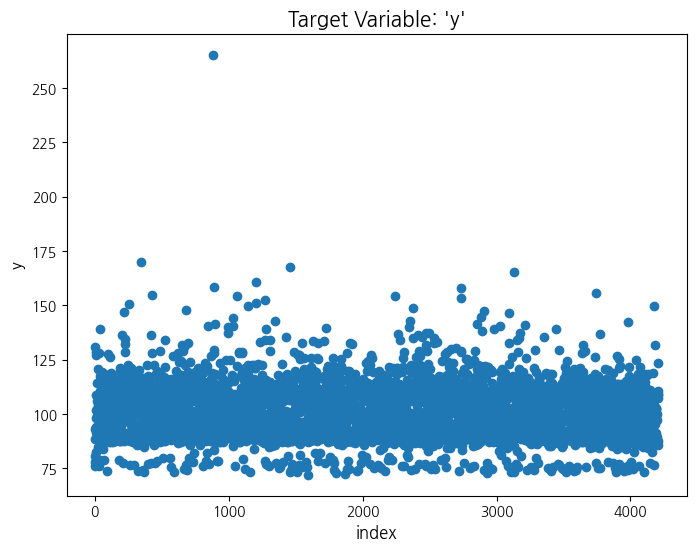

In [7]:
# Target Feature Scatter Plot
plt.figure(figsize = (8, 6))
plt.scatter(train_df.index, train_df.y)
plt.xlabel('index', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.title("Target Variable: 'y'", fontsize = 15)
plt.show()

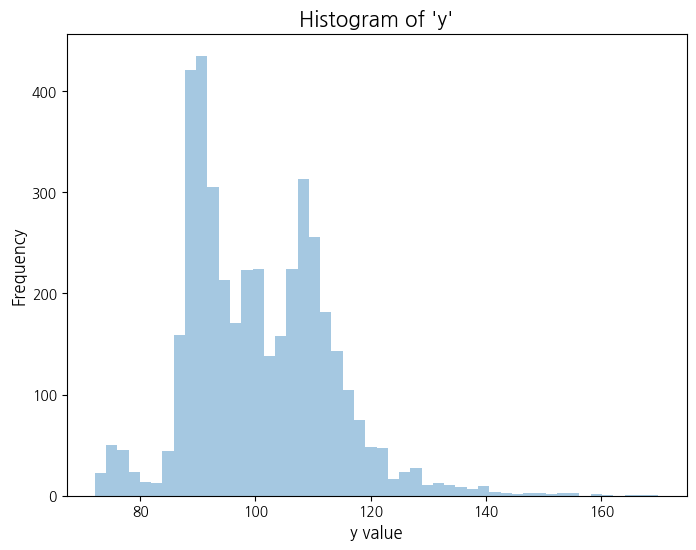

In [39]:
# Histogram
plt.figure(figsize=(8,6))
sns.distplot(train_df.y.values[train_df.y.values < 180], bins = 50, kde=False)
plt.xlabel('y value', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title("Histogram of 'y'", fontsize = 15)
plt.show()

In [9]:
# 테스트 시간 요약
print(train_df.y.describe())

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64


# 3.EDA

In [10]:
dtypes_df = train_df.dtypes.reset_index()
dtypes_df.columns = ["feature","dtype"]
dtypes_df = dtypes_df.groupby('dtype').count().reset_index()
dtypes_df.head()

,dtype,feature
0,int64,369
1,float64,1
2,object,8


In [11]:
# float64 Target Feature, 범주형 변수 8개
train_df.select_dtypes(include=['object','float64']).columns

Index(['y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [12]:
# 범주형 변수
train_df[train_df.select_dtypes(include=['object']).columns].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


In [13]:
# 결측값
print('결측값 :',train_df.isnull().sum().sum())

결측값 : 0


In [14]:
# 설명 변수
cols = [c for c in train_df.columns if 'X' in c]

counts = [[], [],[]]
for c in cols:
  typ = train_df[c].dtype
  uniq = len(np.unique(train_df[c]))
  if uniq == 1:
    counts[0].append(c)
  elif uniq == 2 and typ == np.int64:
    counts[1].append(c)
  else:
    counts[2].append(c)

print('Feature 값이 1개인 경우 : {}'.format(len(counts[0])))
print('Feature 값이 2개인 경우 : {}'.format(len(counts[1])))
print('Feature 값이 범주형인 경우 : {}'.format(len(counts[2])))

Feature 값이 1개인 경우 : 12
Feature 값이 2개인 경우 : 356
Feature 값이 범주형인 경우 : 8


In [15]:
print('Feature 값이 1개인 경우 : {}'.format(counts[0]))
print('Feature 값이 2개인 경우 : {}'.format(counts[1]))
# 범주형
print('Feature 값이 범주형인 경우 : {}'.format(counts[2]))

Feature 값이 1개인 경우 : ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Feature 값이 2개인 경우 : ['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134'

In [16]:
# Feature 값이 1개인 경우
feature = []
for col in counts[0]:
  feature.append(train_df[col].unique()[0])

print('Feature 값이 1개인 유니크한 값 :',list(set(feature)))

Feature 값이 1개인 유니크한 값 : [0]


In [17]:
# Feature 값이 2개인 경우
feature = []
for col in counts[1]:
  feature.append(train_df[col].unique()[0])
print('Feature 값이 2개인 유니크한 값 :',list(set(feature)))

Feature 값이 2개인 유니크한 값 : [0, 1]


In [18]:
# 범주형 변수
feature = []
for col in counts[2]:
  feature.append(train_df[col].unique()[0])
print('Feature 값이 범주형인 유니크한 값 :',list(set(feature)))

Feature 값이 범주형인 유니크한 값 : ['o', 'at', 'a', 'd', 'u', 'j', 'v', 'k']


# 4.Modeling

In [19]:
# Label Encoding
for f in counts[2]:
  lbl = preprocessing.LabelEncoder()
  lbl.fit(list(train_df[f].values))
  train_df[f] = lbl.transform(list(train_df[f].values))

In [20]:
train_y = train_df['y'].values
train_X = train_df.drop(['ID', 'y'], axis=1)

In [21]:
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05, # eta: 학습 속도를 조절하는 학습률로, 각 부스팅 라운드에서의 단계 크기를 축소
    'max_depth': 6, # max_depth: 트리의 최대 깊이
    'subsample': 0.7, # subsample: 각 트리에 대해 무작위로 샘플링할 관측치의 비율
    'colsample_bytree': 0.7, # colsample_bytree: 각 트리에 대해 무작위로 샘플링할 특성의 비율
    'objective': 'reg:linear', # objective: 최적화할 목적 함수로, 여기서는 선형 회귀를 위해 'reg:linear'로 설정.
    'silent': 1 # silent: 출력 메시지의 상세도를 조절하는 매개변수로, 1로 설정하면 XGBoost가 조용해지고 0으로 설정하면 학습 중 메시지가 출력
}

dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.tolist())
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

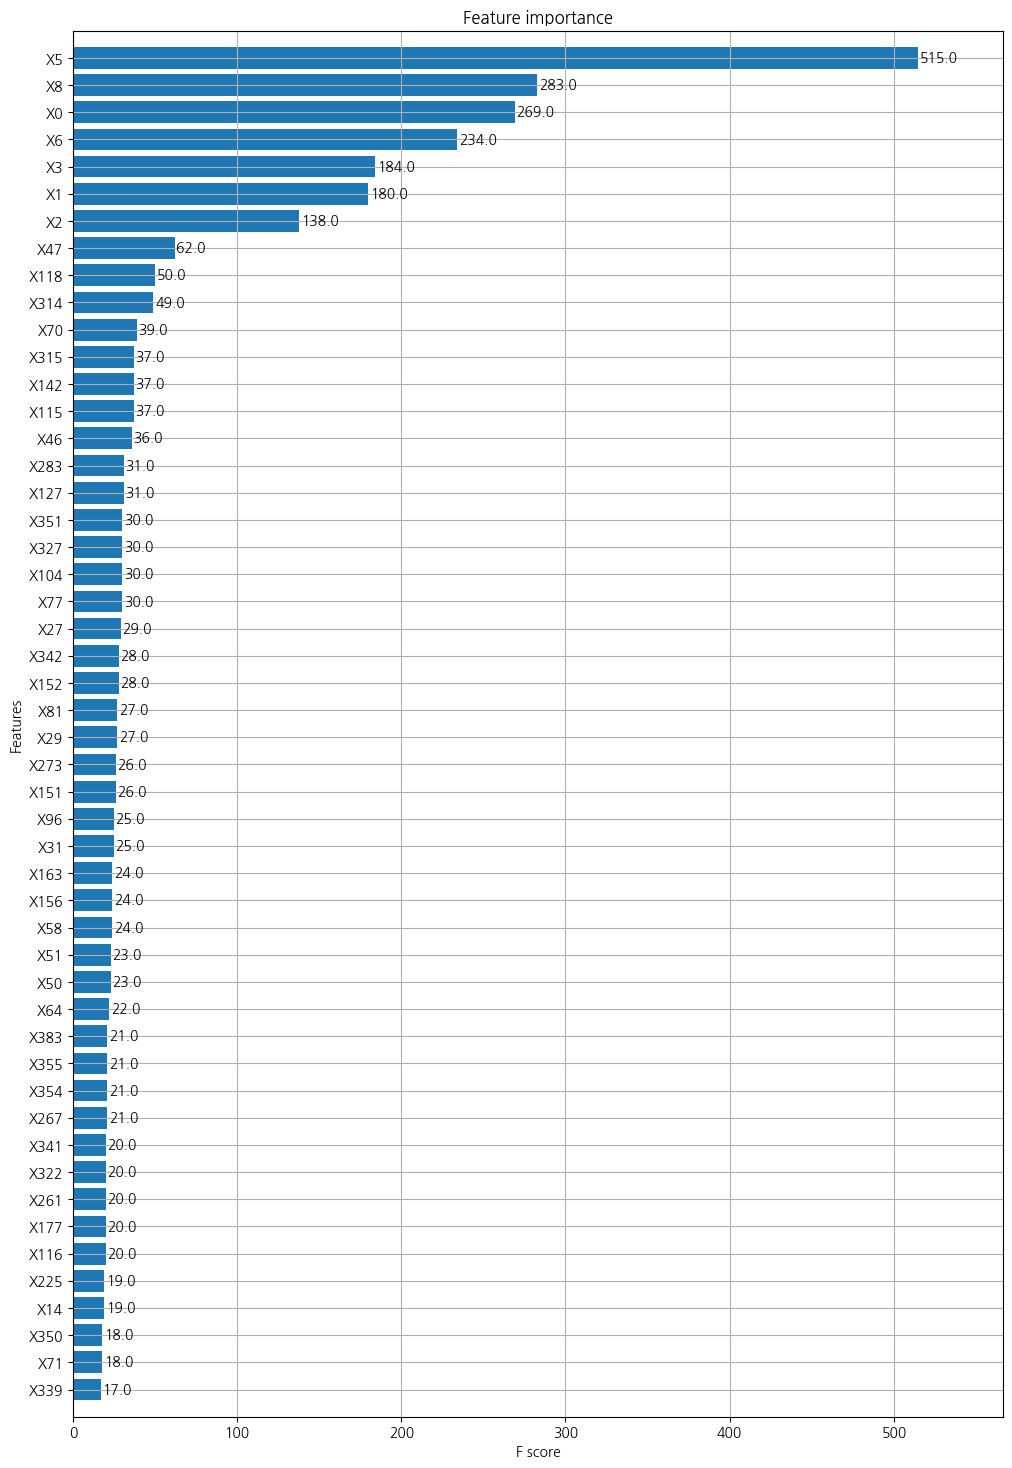

In [22]:
# Feature Importances
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [23]:
# Random Forest Model
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=4, max_features=0.2, n_jobs=-1,random_state=1)
model.fit(train_X, train_y)

RandomForestRegressor(max_features=0.2, min_samples_leaf=4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [24]:
# Feature Importances
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

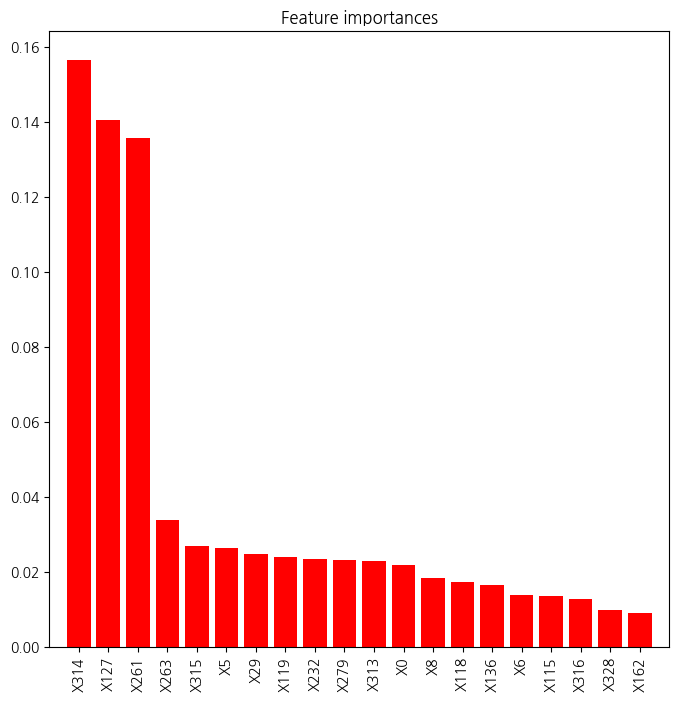

In [25]:
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

# 5.Feature Selection

#### 차원 축소 기법의 종류
* Pricipal Component Analysis (PCA)
* Independent Component Analysis (ICA)
* Truncated SVD (TSVD)
* Gaussain Random Projection (GRP)
* Sparse Random Projection (SRP)
* Non-negative Matrix factorization (NMF)
* Feature Agglomeration (FAG)

In [26]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

y_train = train['y']
train = train.drop('y', axis=1)

In [27]:
# object 라벨 인코딩
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [28]:
n_comp = 12 # 12 차원

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train)
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train)
srp_results_test = srp.transform(test)

# NMF
nmf = NMF(n_components=n_comp, init='nndsvdar', random_state=420)
nmf_results_train = nmf.fit_transform(train)
nmf_results_test = nmf.transform(test)

# FAG
fag = FeatureAgglomeration(n_clusters=n_comp, linkage='ward')
fag_results_train = fag.fit_transform(train)
fag_results_test = fag.transform(test)

In [29]:
dim_reds = list()
train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

train_ica = pd.DataFrame()
test_ica = pd.DataFrame()

train_tsvd = pd.DataFrame()
test_tsvd = pd.DataFrame()

train_grp = pd.DataFrame()
test_grp = pd.DataFrame()

train_srp = pd.DataFrame()
test_srp = pd.DataFrame()

train_nmf = pd.DataFrame()
test_nmf = pd.DataFrame()

train_fag = pd.DataFrame()
test_fag = pd.DataFrame()


for i in range(1, n_comp + 1):
    train_pca['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test_pca['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train_ica['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test_ica['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_tsvd['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train_grp['grp_' + str(i)] = grp_results_train[:, i - 1]
    test_grp['grp_' + str(i)] = grp_results_test[:, i - 1]

    train_srp['srp_' + str(i)] = srp_results_train[:, i - 1]
    test_srp['srp_' + str(i)] = srp_results_test[:, i - 1]

    train_nmf['nmf_' + str(i)] = nmf_results_train[:, i - 1]
    test_nmf['nmf_' + str(i)] = nmf_results_test[:, i - 1]

    train_fag['fag_' + str(i)] = fag_results_train[:, i - 1]
    test_fag['fag_' + str(i)] = fag_results_test[:, i - 1]

dim_reds.append(('pca', train_pca, test_pca))
dim_reds.append(('ica', train_ica, test_ica))
dim_reds.append(('tsvd', train_tsvd, test_tsvd))
dim_reds.append(('grp', train_grp, test_grp))
dim_reds.append(('srp', train_srp, test_srp))
dim_reds.append(('nmf', train_nmf, test_nmf))
dim_reds.append(('fag', train_fag, test_fag))

In [30]:
# 복수의 차원 축소 기법 적용에 따른 성능 실험
combs = [combinations(dim_reds, i + 1) for i in range(0, len(dim_reds))] # 각 차원축소 기법 combination, 1부터 조합 8까지

In [45]:
dr_scores = list()
for c1 in combs:
    for c2 in c1:
        train_, test_, id_ = list(), list(), list()
        for k in c2:
            train_.append(k[1])
            test_.append(k[2])
            id_.append(k[0])
        # 원본 데이터 추가
        train_x = train.reset_index(drop=True)
        train_.append(train_x)
        test_.append(test)

        # 각 차원 축소 결과를 데이터프레임으로 합치기
        train_ = pd.concat(train_, axis=1)
        test_ = pd.concat(test_, axis=1)


# ============================ DecisionTree Model =======================
#         model = DecisionTreeRegressor(max_depth=3, min_samples_split=11, presort=False, random_state=1729)
#         model.fit(train_, y_train)
#         c_score = r2_score(y_train, model.predict(train_))

# ============================ ElasticNet model =======================
        model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.99999999,
                   fit_intercept=False, warm_start=True,
                   copy_X=True, precompute=False, positive=False, max_iter=60)
        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))
# ============================ Ridge model =============================
#         model = Ridge()
#         model.fit(train_, y_train)
#         c_score = r2_score(y_train, model.predict(train_))

# ================================ lightgbm model =======================
#         lgb_params = {
#         'num_iterations': 200,
#         'learning_rate': 0.045,
#         'max_depth': 3,
#         'bagging_fraction': 0.93,
#         'metric': 'l2_root',
#         }

#         dtrain = lgb.Dataset(train_, y_train)
#         num_round = 1200
#         model = lgb.train(lgb_params, dtrain, num_round)
#         c_score = r2_score(y_train, model.predict(train_))

# ================================= xgboost model ============================
#         xgb_params = {
#         'n_trees': 520,
#         'eta': 0.0045,
#         'max_depth': 4,
#         'subsample': 0.93,
#         'objective': 'reg:linear',
#         'eval_metric': 'rmse',
#         'base_score': np.mean(y_train),
#         }

#         dtrain = xgb.DMatrix(train_, y_train)

#         num_boost_rounds = 1250
#         model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
#         c_score = r2_score(y_train, model.predict(dtrain))

        dr_scores.append((','.join(id_), c_score))

In [47]:
# baseline scoring for comparision
model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.99999999,
            fit_intercept=False, warm_start=True,
            copy_X=True, precompute=False, positive=False, max_iter=60)

model.fit(train, y_train)
full_score = r2_score(y_train, model.predict(train))

dr_scores.append(('baseline', full_score))

In [70]:
# Plotting the graph
for i in range(len(dr_scores)):
    if dr_scores[i][1] < 0:
        dr_scores[i] = (dr_scores[i][0], 0)

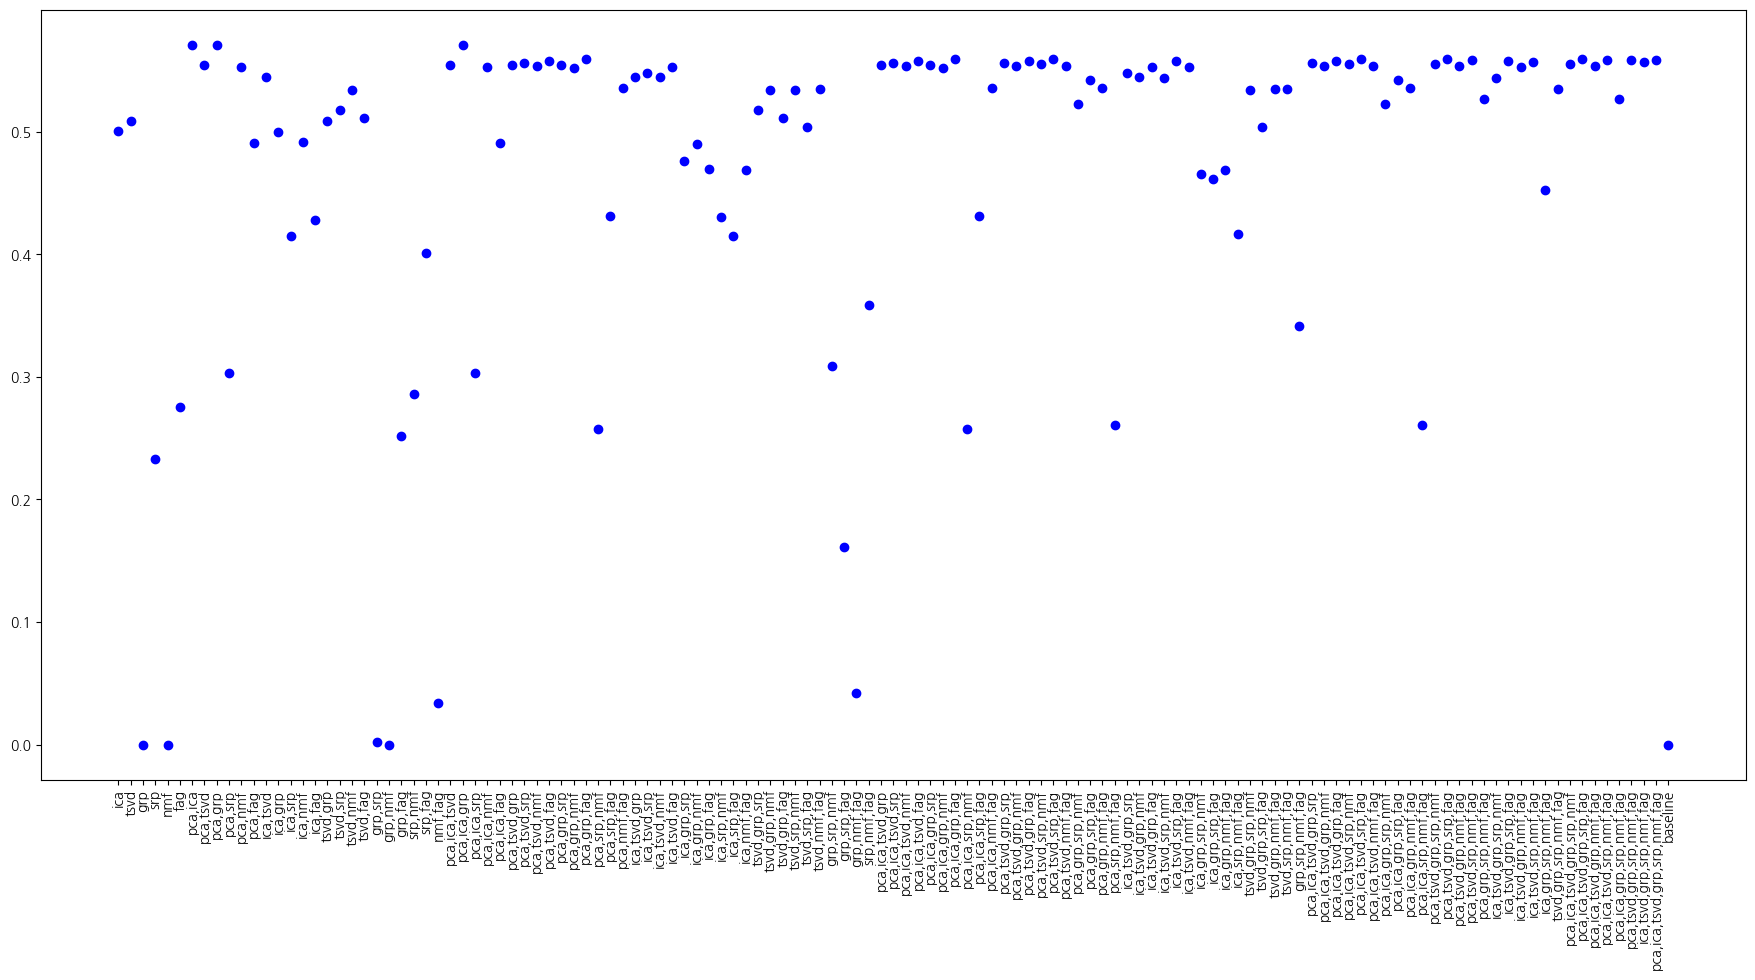

In [73]:
x_axis = [c[0] for c in dr_scores]
y_axis = [c[1] for c in dr_scores]

fig, ax = plt.subplots(figsize=(22, 10))
plt.scatter(x_axis, y_axis, marker='o', color='b')
ax.set_xticks(range(len(x_axis)))
ax.set_xticklabels(x_axis, rotation='vertical')
plt.show()

In [74]:
sorted_id = np.argsort(y_axis)
print("점수 하위 7개 차원 축소 기법 조합 : {}".format(np.array(x_axis)[sorted_id[:7]]))
print("점수 상위 7개 차원 축소 기법 조합 : {}".format(np.array(x_axis)[sorted_id[-7:]]))

print("\n\n가장 높은 점수를 가지는 조합 : {}".format(np.array(x_axis)[sorted_id[-1]]))

점수 하위 7개 차원 축소 기법 조합 : ['baseline' 'grp' 'nmf' 'grp,nmf' 'grp,srp' 'nmf,fag' 'grp,nmf,fag']
점수 상위 7개 차원 축소 기법 조합 : ['pca,tsvd,srp,fag' 'pca,ica,tsvd,srp,fag' 'pca,tsvd,grp,srp,fag'
 'pca,ica,tsvd,grp,srp,fag' 'pca,grp' 'pca,ica,grp' 'pca,ica']


가장 높은 점수를 가지는 조합 : pca,ica


In [52]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
# Dimensionality reduction techniques
n_comp = 12 # 차원 수

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

for i in range(1, n_comp+1):
    train['grp_' + str(i)] = grp_results_train[:,i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]

y_mean = np.mean(y_train)

In [53]:
import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500,
    'eta': 0.005,
    'max_depth':6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}


# Creating DMatrices for Xgboost training
dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=700,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.63807	test-rmse:12.63876
[50]	train-rmse:11.02162	test-rmse:11.17081
[100]	train-rmse:9.85667	test-rmse:10.17348
[150]	train-rmse:9.01866	test-rmse:9.51245
[200]	train-rmse:8.41759	test-rmse:9.09533
[250]	train-rmse:7.98066	test-rmse:8.83651
[300]	train-rmse:7.65559	test-rmse:8.68002
[350]	train-rmse:7.39951	test-rmse:8.58985
[400]	train-rmse:7.19509	test-rmse:8.54057
[450]	train-rmse:7.01525	test-rmse:8.51802
[500]	train-rmse:6.86416	test-rmse:8.50879
[550]	train-rmse:6.73520	test-rmse:8.50714
[600]	train-rmse:6.61679	test-rmse:8.50951
[650]	train-rmse:6.50811	test-rmse:8.51274
[699]	train-rmse:6.41149	test-rmse:8.51782
700


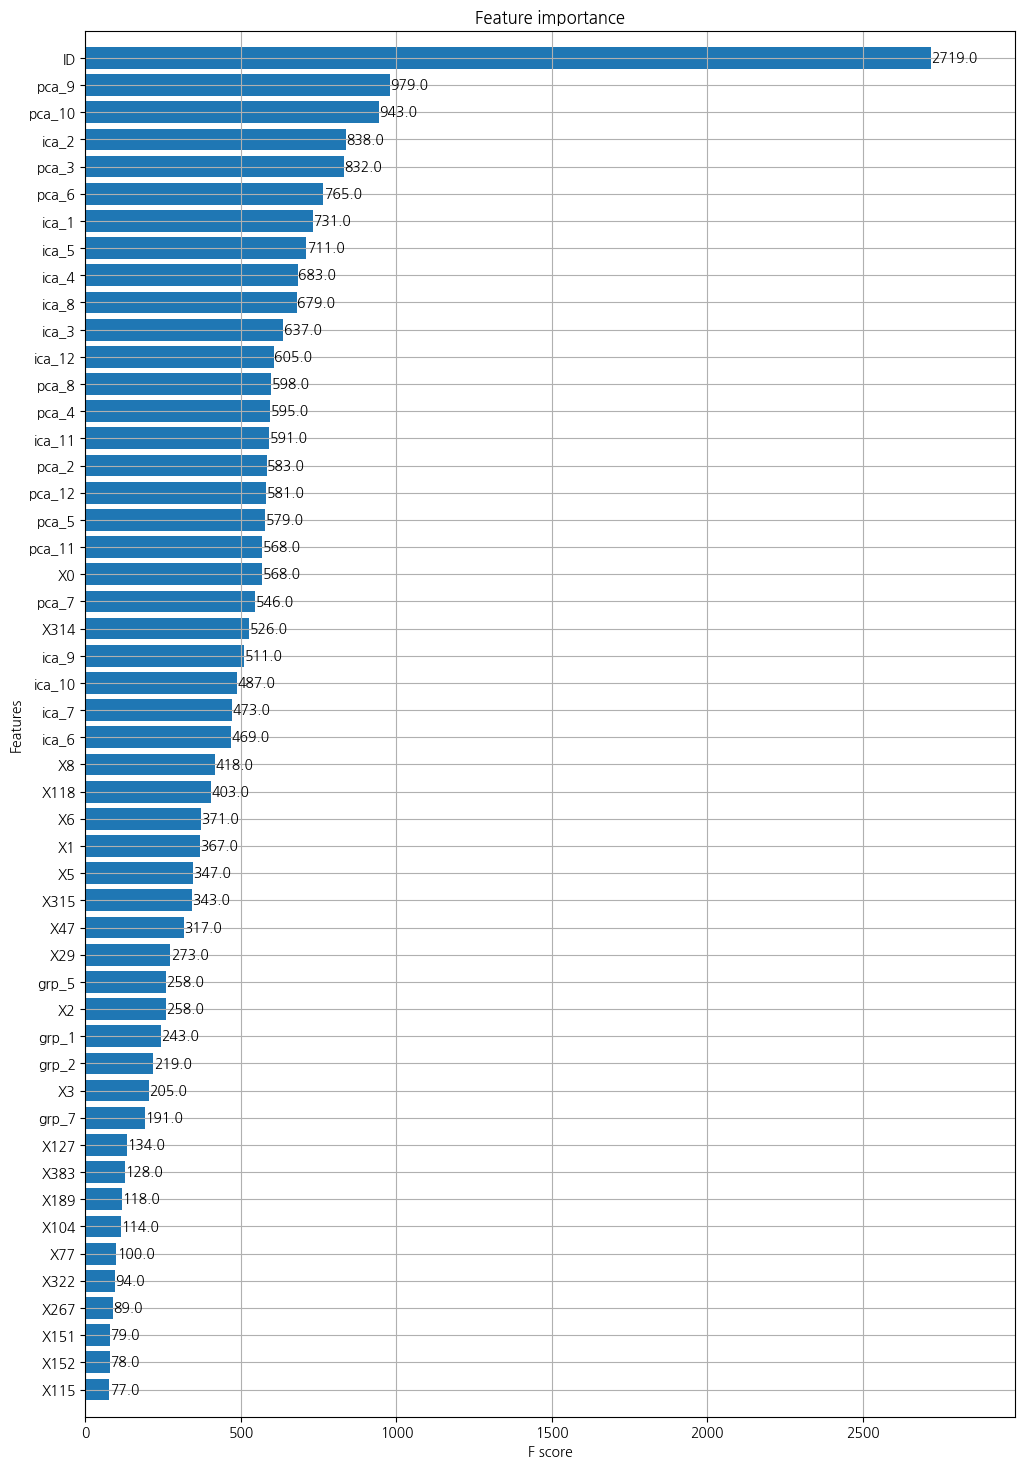

In [54]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [55]:
from sklearn.metrics import r2_score

print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.710779645902047


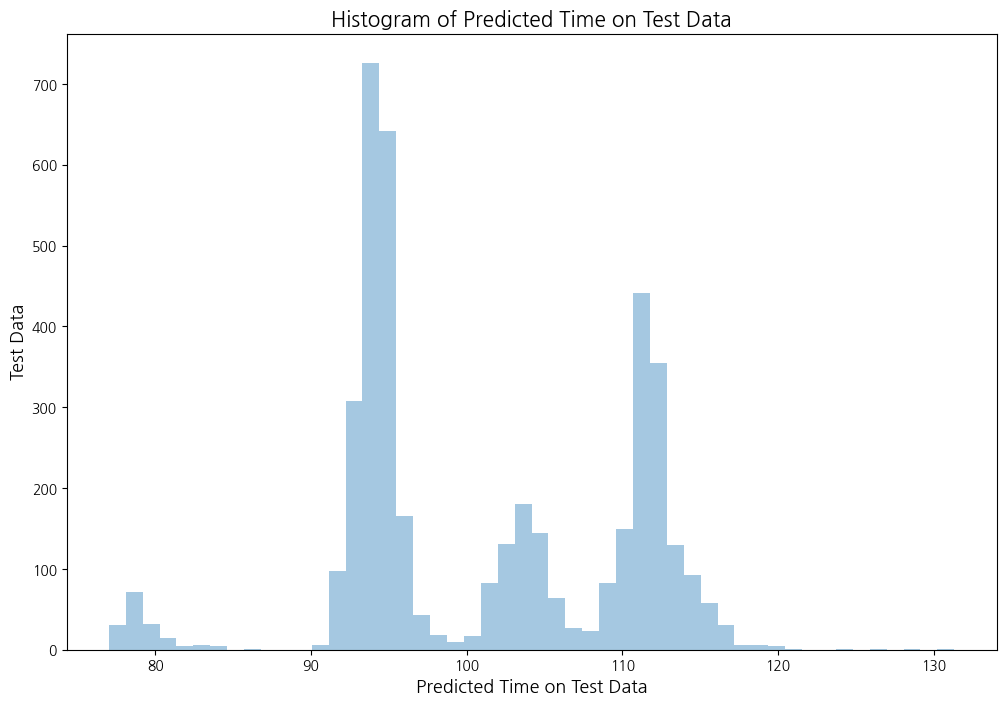

In [56]:
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('XGB_test_results.csv', index=False)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

# 6.Stacked Regression Model

#### 각 Estimator 의 결과를 합칠 클래스 생성
* BaseEstimator : https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html
* TransformerMixin : https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html

> 파이썬 클래스, 상속, 멤버 변수, 생성자 등의 기초 지식 필요

In [96]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self

    """
    1. np.hstack : 두 배열을 가로로 이어붙이는 함수
    2. predict_proba 의 출력은 각 클래스에 대한 확률
    3. issubclass(subclass, superclass) -> subclass가 superclass의 자식 클래스인지, 다시 말해 subclass가 superclass를 상속받는지 판단해 True, False 를 반환
    4. hasattr(self.estimator, 'predict_proba') -> self.estimator(우리의 머신러닝 모델) 에 'predict_proba' 라는 멤버가 있는지 판단해 True, False 를 반환
    """

    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)

        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):

            # X 에 각 클래스에 대한 확률을 이어 붙여준다.
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # 위의 X_transformed 에 예측 클래스를 이어 붙여준다.
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [57]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [88]:
# Label Encoding
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))# Fit label encoder
        train[c] = lbl.transform(list(train[c].values))# Transform labels to normalized encoding.
        test[c] = lbl.transform(list(test[c].values))# Transform labels to normalized encoding.

In [89]:
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(["ID"], axis=1)
test = test.drop(["ID"], axis=1)

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

usable_columns = list(set(train.columns) - set(['y']))

In [90]:
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

for i in range(1, n_comp+1):

    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]

    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]

    train['grp_' + str(i)] = grp_results_train[:, i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['srp_' + str(i)] = srp_results_train[:, i-1]
    test['srp_' + str(i)] = srp_results_test[:,i-1]

In [91]:
final_train = train[usable_columns].values
final_test = test[usable_columns].values

import xgboost as xgb

xgb_params = {
    'n_trees': 500,
    'eta': 0.005,
    'max_depth':5,
    'subsample': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1}

In [92]:
# DMatrix : Numpy 입력 파라미터를 받아서 만들어지는 XGBoost 전용 데이터 --> Input : Feature 데이터, Label 데이터
dtrain = xgb.DMatrix(train.drop(["y"], axis=1), train_y)
dtest = xgb.DMatrix(test)

In [93]:
# xgboost & cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=1000,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

[0]	train-rmse:12.63976	test-rmse:12.63844
[50]	train-rmse:11.05325	test-rmse:11.14959
[100]	train-rmse:9.91978	test-rmse:10.14846
[150]	train-rmse:9.11985	test-rmse:9.49247
[200]	train-rmse:8.56438	test-rmse:9.07065
[250]	train-rmse:8.16795	test-rmse:8.80868
[300]	train-rmse:7.88597	test-rmse:8.65006
[350]	train-rmse:7.66371	test-rmse:8.55666
[400]	train-rmse:7.48818	test-rmse:8.50513
[450]	train-rmse:7.33015	test-rmse:8.47867
[500]	train-rmse:7.18599	test-rmse:8.46621
[550]	train-rmse:7.06263	test-rmse:8.46137
[600]	train-rmse:6.94963	test-rmse:8.46162
[650]	train-rmse:6.84792	test-rmse:8.46259
[700]	train-rmse:6.75178	test-rmse:8.46854
[750]	train-rmse:6.65518	test-rmse:8.47477
[800]	train-rmse:6.56865	test-rmse:8.48106
[850]	train-rmse:6.48932	test-rmse:8.48649
[900]	train-rmse:6.40744	test-rmse:8.49457
[950]	train-rmse:6.32715	test-rmse:8.50206
[999]	train-rmse:6.25598	test-rmse:8.51044
1000


In [94]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

In [97]:
from sklearn.pipeline import make_pipeline, make_union
Stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001,loss="huber",max_features=0.55,
                                                          min_samples_leaf=18,
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())


Stacked_pipeline.fit(final_train, train_y)
predictions = Stacked_pipeline.predict(final_test)

In [98]:
print('R2 score on train data:')
print(r2_score(train_y,Stacked_pipeline.predict(final_train)*0.2855 + model.predict(dtrain)*0.7145))

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred*0.75 + predictions*0.25
sub.to_csv('stacked_model_pred.csv', index=False)

R2 score on train data:
0.68521947306756


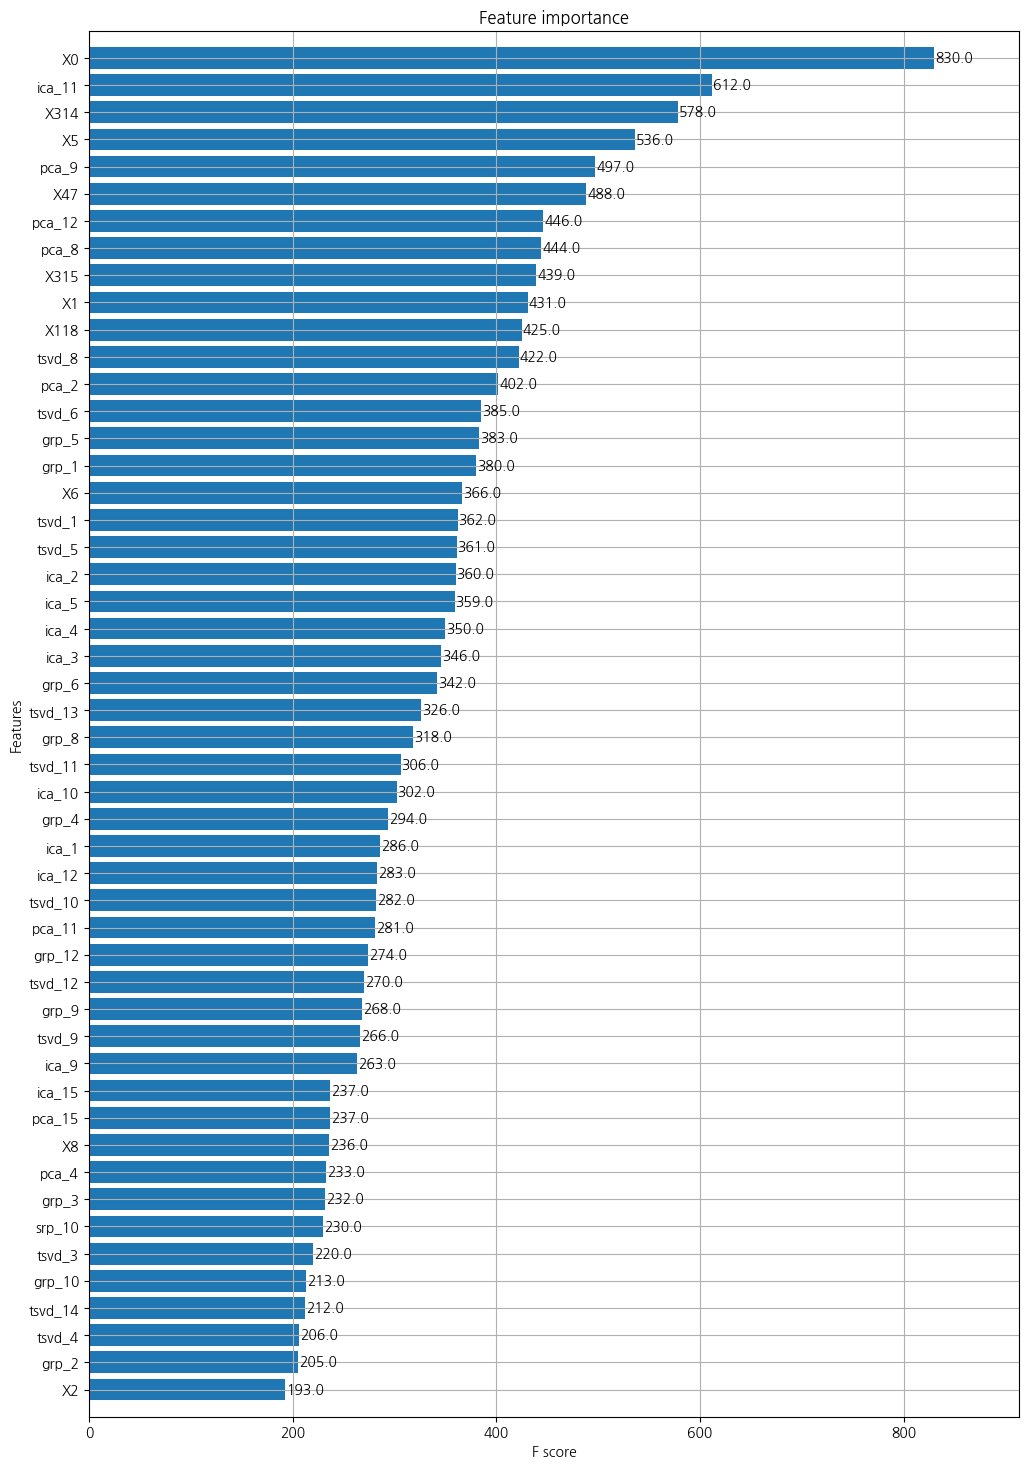

In [99]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()